In [10]:
import random as random
import time as time
import heapq as heapq
import matplotlib.pyplot as plt # 画曲线图
import numpy as np #拟合直线
from src.Data import HyperNode,HyperEdge,Heap,load_data,recoder,K_core,degree_distribute

# return: part_node,part_edge
def solve(p,path,prop = 1.0,k=1,shield_heavy_edge = 1e9 ,buffer_fac = 5,debug = False):
    # input : 
    # p: partition number 
    # mp_node: dict of partition nodes  
    # mp_edge: dict of partition edges
    # prob: accelerate factory to add node
    # k: select topk node at once
    # shield_heavy_node: filter huge edge 
    # debug: print debug infomation
    
    # return :
    # part_node: list of partition node set 
    # part_edge: list of partition edge set
    mp_node,mp_edge = load_data(path)
    random.seed(19990320)
    node_number = len(mp_node)
    cur_p = 0
    maxi_cap = node_number/p + 1
    part_node = [set() for i in range(p)]
    part_edge = [set() for i in range(p)]
    mp_eval = {i:0 for i in mp_node.keys()}
    
    ave_hyperedge_degree = 0
    edge_degree_list = set()
    for edge in mp_edge.values():   
        ave_hyperedge_degree += edge.degree/len(mp_edge)
        edge_degree_list.add(edge.degree)
#     print(edge_degree_list)
    edge_degree_list = list(edge_degree_list)
    edge_degree_list.sort()
#     print(edge_degree_list)
#     print(len(mp_edge)/2)
#     print("2*ave:",ave_hyperedge_degree," mid:",edge_degree_list[int(len(edge_degree_list)/2)])
    ave_hyperedge_degree = edge_degree_list[int(len(edge_degree_list)/2)]

    cnt = 0
    select_node = Heap()
    heap_size = buffer_fac*k*2
    while len(mp_node)!=0:
        cnt += 1
        if cnt % 100 == 0 and debug : print (cnt)
            
        add_node = []
        
        if select_node.size() <= heap_size/2:
            select_node.clear()
            for node in mp_node.values():   
                if  select_node.size() < heap_size:
                    select_node.add(mp_eval[node.id],node)
                else :
                    if mp_eval[node.id] > select_node.top()[0] :
                        rank,remove_node = select_node.pop()
                        select_node.add(mp_eval[node.id],node)
        
        for i in range(min(k,select_node.size())):
            rank,node = select_node.pop()
            add_node.append(node)

        for par_node in add_node:
            if len(part_node[cur_p]) >= maxi_cap :
                break
            part_node[cur_p].add(par_node)
            for edge in par_node.edges:
                if edge not in part_edge[cur_p]:
                    part_edge[cur_p].add(edge)
                    if mp_edge[edge].degree > shield_heavy_edge: continue
                    for node in mp_edge[edge].nodes:
                        if mp_node.get(node) == None : continue
                        mp_eval[node] += 1
#                         print(len(select_node))
            del mp_node[par_node.id] 
        remake_ls = [(mp_eval[node.id],node) for rank,node in select_node.heap]
#         print(remake_ls)
        select_node.remake(remake_ls)

        if len(part_node[cur_p]) >= maxi_cap : # next partition pre-process
            for key in mp_eval.keys():
                mp_eval[key] = 0
            cur_p += 1   
            
    return part_node,part_edge
        
        
def solve2(p,path,prop = 1.0,k=1,shield_heavy_edge = 1e9 ,buffer_fac = 5,debug = False):
    # input : 
    # p: partition number 
    # mp_node: dict of partition nodes  
    # mp_edge: dict of partition edges
    # prob: accelerate factory to add node
    # k: select topk node at once
    # shield_heavy_node: filter huge edge 
    # debug: print debug infomation
    
    # return :
    # part_node: list of partition node set 
    # part_edge: list of partition edge set
    mp_node,mp_edge = load_data(path)
    random.seed(19990320)
    node_number = len(mp_node)
    cur_p = 0
    maxi_cap = node_number/p + 1
    part_node = [set() for i in range(p)]
    part_edge = [set() for i in range(p)]
    mp_eval = {i:0 for i in mp_node.keys()}

    cnt = 0
    select_node = Heap()
    heap_size = buffer_fac*k
    kcore = K_core(path)
    
    while len(mp_node)!=0:
        cnt += 1
        if cnt % 100 == 0 and debug : print (cnt)
            
        add_node = []
        if len(part_node[cur_p]) == 0:
            result = kcore.get_kcore(10)
            for node in kcore.find_connection(result):
                add_node.append(mp_node[node.id])
        else:
            if select_node.size() <= heap_size/2:
                select_node.clear()
                for node in mp_node.values(): 
                    if  select_node.size() < heap_size:
                        select_node.add(mp_eval[node.id],node)
                    else :
                        if mp_eval[node.id] > select_node.top()[0] :
                            rank,remove_node = select_node.pop()
                            select_node.add(mp_eval[node.id],node)

            for i in range(min(k,select_node.size())):
                rank,node = select_node.pop()
                add_node.append(node)

        for par_node in add_node:
            if len(part_node[cur_p]) >= maxi_cap :
                break
            part_node[cur_p].add(par_node)
            kcore.del_node([par_node])
            for edge in par_node.edges:
                if edge not in part_edge[cur_p]:
                    part_edge[cur_p].add(edge)
                    if mp_edge[edge].degree > shield_heavy_edge: continue
                    for node in mp_edge[edge].nodes:
                        if mp_node.get(node) == None : continue
                        mp_eval[node] += 1
#                         print(len(select_node))
            del mp_node[par_node.id] 
        remake_ls = [(mp_eval[node.id]-node.degree,node)for rank,node in select_node.heap]
        select_node.remake(remake_ls)

        if len(part_node[cur_p]) >= maxi_cap : # next partition pre-process
            for key in mp_eval.keys():
                mp_eval[key] = 0
            cur_p += 1   
            
    return part_node,part_edge



data set: ./data/github/github.txt
alpha: -1.6363240049196743


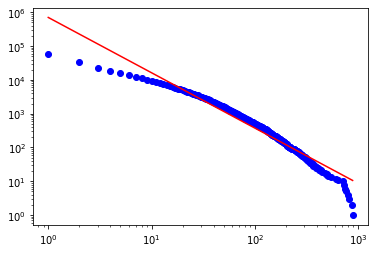

parameter:
 p: 2  prop: 1.10  k: 10  buffer_fac: 10  sheld_size: 1000000000.0
result1:
 runtime: 13399 ms k-1: 13635
2   94096
2   40405
k: 47  node number: 15  edge number: 3
k: 4  node number: 14  edge number: 15
result2:
 runtime: 26610 ms k-1: 5780
2   95200
2   31446
---------------------------------------
parameter:
 p: 4  prop: 1.10  k: 10  buffer_fac: 10  sheld_size: 1000000000.0
result1:
 runtime: 15434 ms k-1: 23963
4   77295
4   20567
4   21658
4   25309
k: 47  node number: 15  edge number: 3
k: 6  node number: 13  edge number: 22
k: 5  node number: 18  edge number: 11
k: 2  node number: 2328  edge number: 892
result2:
 runtime: 33325 ms k-1: 14031
4   78504
4   19652
4   21089
4   15652
---------------------------------------
parameter:
 p: 8  prop: 1.10  k: 10  buffer_fac: 10  sheld_size: 1000000000.0
result1:
 runtime: 17633 ms k-1: 41388
8   60321
8   25679
8   16889
8   7903
8   13248
8   11056
8   11232
8   15926
k: 47  node number: 15  edge number: 3
k: 9  node number

result1:
 runtime: 22323 ms k-1: 130550
128   15552
128   12636
128   8573
128   10920
128   7888
128   7985
128   8377
128   6231
128   7360
128   5116
128   3982
128   5124
128   3879
128   4310
128   5029
128   4402
128   3872
128   3233
128   4922
128   2901
128   4208
128   2700
128   3183
128   2794
128   3549
128   2627
128   2624
128   2227
128   2423
128   1570
128   2844
128   1865
128   1772
128   1411
128   2649
128   1898
128   1844
128   1536
128   2238
128   1307
128   1847
128   1221
128   2748
128   1077
128   1455
128   868
128   2479
128   835
128   1921
128   651
128   1336
128   705
128   1620
128   820
128   1015
128   636
128   2573
128   531
128   1888
128   485
128   1423
128   520
128   617
128   687
128   866
128   1147
128   1070
128   602
128   968
128   737
128   1114
128   874
128   918
128   832
128   862
128   797
128   843
128   835
128   823
128   766
128   825
128   849
128   814
128   683
128   766
128   702
128   742
128   653
128   678
128   641
1

k: 47  node number: 15  edge number: 3
k: 34  node number: 81  edge number: 70
k: 28  node number: 77  edge number: 83
k: 25  node number: 46  edge number: 61
k: 22  node number: 185  edge number: 126
k: 20  node number: 121  edge number: 142
k: 19  node number: 20  edge number: 66
k: 17  node number: 191  edge number: 184
k: 16  node number: 133  edge number: 164
k: 15  node number: 141  edge number: 185
k: 14  node number: 207  edge number: 201
k: 13  node number: 331  edge number: 258
k: 13  node number: 31  edge number: 126


KeyError: '8929'

In [12]:
path = "./data/github/github.txt"
# path = "./data/wiki/wiki.txt"
print("data set:",path)
p = 1
mp_node,mp_edge = load_data(path)
ls = degree_distribute(mp_node)
for turn in range(8):
    p*=2
    prop = 1.1
    k = 10
    buffer_fac = 10
    shield_heavy_edge = 1e9
    print("parameter:\n","p:",p," prop:","%.2f"%prop," k:",k," buffer_fac:",buffer_fac,
      " sheld_size:",shield_heavy_edge)
        
    time_beg = time.time()
    part_node,part_edge = solve(p,path,prop,k,buffer_fac = buffer_fac,shield_heavy_edge = shield_heavy_edge)  
    time_end = time.time()
    mp_node,mp_edge = load_data(path)
    # recoder(part_node,mp_node,mp_edge,"./data/wiki")
    k_1 = sum([len(i) for i in part_edge]) - len(mp_edge)
#     print(turn," ",k_1)
    print("result1:\n","runtime:",int((time_end-time_beg)*1000),"ms k-1:",k_1)
    for par in range(p):
        print(p," ",len(part_edge[par]))
    
    time_beg = time.time()
    part_node,part_edge = solve2(p,path,prop,k,buffer_fac = buffer_fac,shield_heavy_edge = shield_heavy_edge)  
    time_end = time.time()
    mp_node,mp_edge = load_data(path)
    # recoder(part_node,mp_node,mp_edge,"./data/wiki")
    k_1 = sum([len(i) for i in part_edge]) - len(mp_edge)
    print("result2:\n","runtime:",int((time_end-time_beg)*1000),"ms k-1:",k_1)
    for par in range(p):
        print(p," ",len(part_edge[par]))
    print("---------------------------------------")
#  runtime: 11999 ms k-1: 27102
    

In [ ]:
def test_shield():
    x = []
    y = []
#     path = "./data/wiki/wiki.txt"
    path = "./data/github/github.txt"
    p = 16
    mp_node,mp_edge = load_data(path)
    ls = degree_distribute(mp_node)
    for turn in range(61,81):
    #     p*=2
        mp_node,mp_edge = load_data(path)
    #     degree_distribute(mp_node)
        time_beg = time.time()
        prop = 1.1
        k = 10
        buffer_fac = 1
        shield_heavy_edge = turn
        part_node,part_edge = solve(p,mp_node,mp_edge,prop,k,buffer_fac = buffer_fac,shield_heavy_edge = shield_heavy_edge)  
        time_end = time.time()
        mp_node,mp_edge = load_data(path)
        # recoder(part_node,mp_node,mp_edge,"./data/wiki")
        k_1 = sum([len(i) for i in part_edge]) - len(mp_edge)
#         print(turn," ",k_1)
        x.append(turn)
        y.append(k_1)
    plt.plot(x,y,color='r')
    plt.show()
    return x,y
    
x,y = test_shield()

In [6]:
path = "./data/github/github.txt"
mp_node,mp_edge = load_data(path)
ls = degree_distribute(mp_node)
sum = 0
p60 = 0
p80 = 0
for i,j in ls:
    if i < 60 : p60 += j
    if i < 80 : p80 += j
    sum += j
print(p60/sum*100," ",p80/sum*100)

TypeError: 'int' object is not callable

In [5]:
for i in range(len(x)):
    print(x)

NameError: name 'x' is not defined

In [23]:
tmp_node = [set() for i in range(p)]

for par in range(len(part_edge)):
    for i in part_node[par]: tmp_node[par].add(i.id)
    cnt = 0
    print("edges:"+str(len(part_edge[par])))
    print("nodes:"+str(len(part_node[par])))
    for edge in part_edge[par]:
        for node in mp_edge[edge].nodes:
#             print(node)
#             print(mp_node[node])
            if node in tmp_node[par]:
                cnt += 1
    cur_p += 1
    print(cnt)
    

edges:56433
nodes:5653
277912
edges:25730
nodes:5653
59056
edges:15618
nodes:5653
28610
edges:7641
nodes:5653
14208
edges:7349
nodes:5653
12455
edges:7531
nodes:5653
11444
edges:7756
nodes:5653
10089
edges:8023
nodes:5653
9310
edges:7767
nodes:5653
8748
edges:7984
nodes:5642
8405


In [4]:
k_1 = sum([len(i) for i in part_edge]) - edge_number
print(k_1)

30965
